In [4]:
import os
import shutil
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from pathlib import Path

# Data visualisation 
import pandas as pd 
import seaborn as sns 

# Image manipulation
from PIL import Image
from skimage.io import imread
import cv2

# Specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import numpy as np 

# Plotting library
from mpl_toolkits.mplot3d import Axes3D  # needed to plot 3-D surfaces

# dl libraries specifically for CNN
import tensorflow as tf
from tensorflow import keras
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import optimizers

# training set
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

# Tells matplotlib to embed plots within the notebook
%matplotlib inline

import math

In [5]:
!git clone https://github.com/Shahbaz64/flowers-classification

Cloning into 'flowers-classification'...
remote: Enumerating objects: 4368, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 4368 (delta 1), reused 10 (delta 1), pack-reused 4358
Receiving objects: 100% (4368/4368), 230.16 MiB | 17.19 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Checking out files: 100% (7797/7797), done.


In [17]:
!git clone https://github.com/Hina-Akram/flower-classification.git

Cloning into 'flower-classification'...
remote: Enumerating objects: 4368, done.
remote: Total 4368 (delta 0), reused 0 (delta 0), pack-reused 4368
Receiving objects: 100% (4368/4368), 230.16 MiB | 16.65 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Checking out files: 100% (7797/7797), done.


In [7]:
# Dataset folder
flowersPath = Path('/content/flowers-classification/flowersData')

# Each species of flower is contained in a separate folder, & this is to get all the sub-directories
flowers = os.listdir(flowersPath)
print("Number of types of flowers: ", len(flowers))
print("Types of flowers: ", flowers)

# A list which contains tuples, the type of flower and the corresponding image path
flowersList = []

for species in flowers:
    # Get all the file names
    allFlowers = os.listdir(flowersPath / species)
    # Add them to the list
    for flower in allFlowers:
        flowersList.append((species, str(flowersPath /species) + '/' + flower))

# Build a dataframe   
# load the dataset as a pandas data frame     
flowersList = pd.DataFrame(data=flowersList, columns=['category', 'image'], index=None)
flowersList.head()

Number of types of flowers:  5
Types of flowers:  ['sunflower', 'daisy', 'dandelion', 'rose', 'tulip']


,category,image
0,sunflower,/content/flowers-classification/flowersData/su...
1,sunflower,/content/flowers-classification/flowersData/su...
2,sunflower,/content/flowers-classification/flowersData/su...
3,sunflower,/content/flowers-classification/flowersData/su...
4,sunflower,/content/flowers-classification/flowersData/su...


Total number of flowers in the dataset:  3459
Flowers in each category: 
tulip        984
rose         784
daisy        769
sunflower    734
dandelion    188
Name: category, dtype: int64


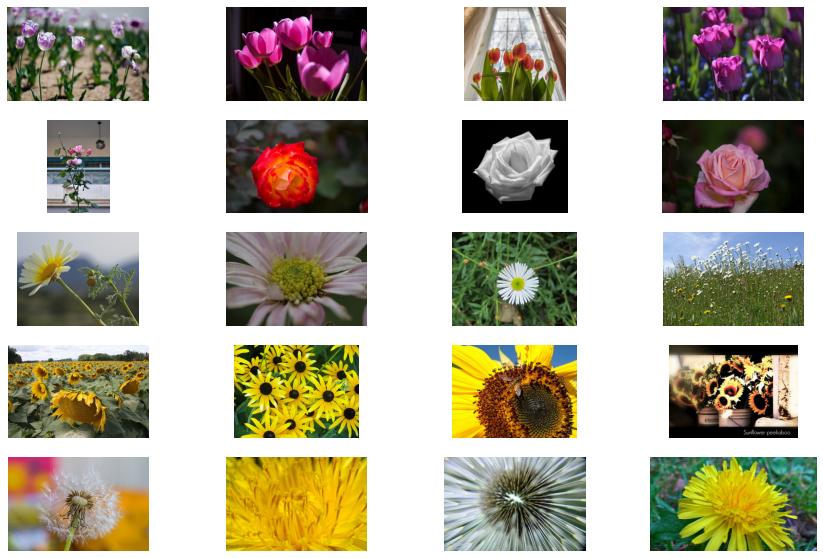

In [8]:
# Let's check how many samples for each category are present
print("Total number of flowers in the dataset: ", len(flowersList))
flowerNum = flowersList['category'].value_counts()
print("Flowers in each category: ")
print(flowerNum)

# A list for storing names of some random samples from each category
RanSamples = []

# Get samples fom each category 
for category in flowerNum.index:
    samples = flowersList['image'][flowersList['category'] == category].sample(4).values
    for sample in samples:
        RanSamples.append(sample)

# Plot the samples
f, ax = plt.subplots(5,4, figsize=(15,10))
for i,sample in enumerate(RanSamples):
    ax[i//4, i%4].imshow(mimg.imread(RanSamples[i]))
    ax[i//4, i%4].axis('off')
plt.show()  

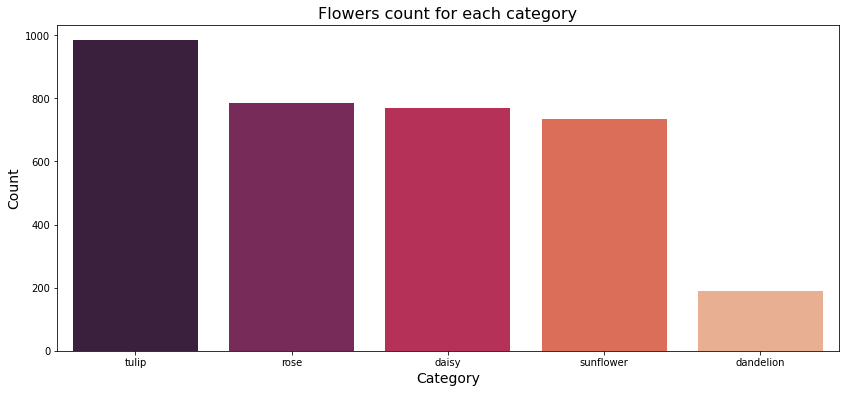

In [9]:
# Let's do some visualization and see how many samples we have for each category
f, axe = plt.subplots(1,1,figsize=(14,6))
sns.barplot(x = flowerNum.index, y = flowerNum.values, ax = axe, palette="rocket")
axe.set_title("Flowers count for each category", fontsize=16)
axe.set_xlabel('Category', fontsize=14)
axe.set_ylabel('Count', fontsize=14)
plt.show()

In [10]:
# Make directory 'test', with 2 sub directories, 'trainDir', & 'validDir'
trainDir = '/content/flowers-classification/test/trainDir'
valDir = '/content/flowers-classification/test/valDir'
# test_dir = './test/test_dir'
def create_directory(dirName):
    if os.path.exists(dirName):
        shutil.rmtree(dirName)
    os.makedirs(dirName)
    # Inside the trainDir & valDir sub-directories, sub-directories for each flower is created
    for flower in flowers:
        os.makedirs(os.path.join(dirName, flower))
create_directory(trainDir)
create_directory(valDir)


# lists for training & validation image & label
trainImg = []
trainLabel = []
validImg = []
validLabel = []

# for copying 100 samples to the validation dir & others to the train dir
for flower in flowerNum.index:
    samples = flowersList['image'][flowersList['category'] == flower].values
    diffPics = np.random.permutation(samples)
    
    for i in range(100):
        name = diffPics[i].split('/')[-1]
        shutil.copyfile(diffPics[i],'/content/flowers-classification/test/trainDir/' + str(flower) + '/'+ name)
        
        try:
            # add image to list
            img = plt.imread('/content/flowers-classification/test/trainDir/' + str(flower) + '/'+ name) 
            #resize all of the image to 150*150
            img = cv2.resize(img,(150,150))
            validImg.append(np.array(img))
            
            # add label to list
            if (str(flower)=="dandelion"):
                validLabel.append(0)
            elif (str(flower)=="tulip"):
                validLabel.append(1)
            elif (str(flower)=="rose"):
                validLabel.append(2)
            elif (str(flower)=="daisy"):
                validLabel.append(3)
            elif (str(flower)=="sunflower"):
                validLabel.append(4)
        except Exception as e:
            None
        
    for i in range(101,len(diffPics)):
        name = diffPics[i].split('/')[-1]
        shutil.copyfile(diffPics[i],'/content/flowers-classification/test/trainDir/' + str(flower) + '/' + name)

        try:
            # add image to list
            img = plt.imread('/content/flowers-classification/test/trainDir/' + str(flower) + '/' + name) 
            #resize all of the image to 150*150
            img = cv2.resize(img,(150,150))
            trainImg.append(np.array(img))
            
            # add label to list
            if (str(flower)=="dandelion"):
                trainLabel.append(0)
            elif (str(flower)=="tulip"):
                trainLabel.append(1)
            elif (str(flower)=="rose"):
                trainLabel.append(2)
            elif (str(flower)=="daisy"):
                trainLabel.append(3)
            elif (str(flower)=="sunflower"):
                trainLabel.append(4)
        except Exception as e:
            None
           
# Let computer read the 5 category
validLabel = to_categorical(validLabel,num_classes = 5)
trainLabel = to_categorical(trainLabel,num_classes = 5)
print(validLabel)
print(trainLabel)

# Make new test and validation images as pixcel
validImg=np.array(validImg)
validImg=validImg/255

trainImg=np.array(trainImg)
trainImg=trainImg/255

print("\nLengths of the corresponding array dimensions: \n")
print(np.shape(validImg),np.shape(validLabel),np.shape(trainImg),np.shape(trainLabel))

[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]

Lengths of the corresponding array dimensions: 

(500, 150, 150, 3) (500, 5) (2953, 150, 150, 3) (2953, 5)


In [11]:
def createModel():
    model = Sequential()
    #  learn a total of 32 filters, kernel size 3x3
    model.add(Conv2D(32, (3, 3), input_shape=(150,150,3), padding="Same", activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    #  learn a total of 64 filters, kernel size 3x3
    model.add(Conv2D(64, (3, 3), padding="Same", activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    #  learn a total of 96 filters, kernel size 3x3
    model.add(Conv2D(96, (3, 3), padding="Same", activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    
    #  learn a total of 128 filters, kernel size 3x3
    model.add(Conv2D(128, (3, 3), padding="Same", activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Add Dense layers on top
    '''
    1. flatten the 3D output to 1D
    2. add dense layer to top
    '''
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    return model

In [12]:
# Compile
model = createModel()
batch_size = 128
epochs = 50

model.compile(loss='categorical_crossentropy',
             optimizer='RMSProp',
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 96)       0

In [13]:
# Create data argument to prevent overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (90, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        shear_range=0.1,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False  # randomly flip images
)
datagen.fit(trainImg)

# start training
'''
verbose - 0 shows nothing; 1 will show animated progress bar; 2 will only mention the number of epoch.
batch_size - the number of samples that will be propagated through the network.
epochs - an arbitrary cutoff, use to separate training into distinct phases.
'''
History = model.fit(trainImg, trainLabel, batch_size=batch_size, epochs = epochs, validation_data = (validImg, validLabel),verbose=1)

Epoch 1/50
24/24 [==============================] - 14s 153ms/step - loss: 1.7742 - accuracy: 0.3048 - val_loss: 1.6192 - val_accuracy: 0.2960
Epoch 2/50
24/24 [==============================] - 3s 106ms/step - loss: 1.2469 - accuracy: 0.4809 - val_loss: 1.5218 - val_accuracy: 0.4220
Epoch 3/50
24/24 [==============================] - 3s 105ms/step - loss: 1.0357 - accuracy: 0.5930 - val_loss: 1.7078 - val_accuracy: 0.2800
Epoch 4/50
24/24 [==============================] - 3s 106ms/step - loss: 1.0453 - accuracy: 0.5737 - val_loss: 1.3119 - val_accuracy: 0.4760
Epoch 5/50
24/24 [==============================] - 3s 107ms/step - loss: 0.9564 - accuracy: 0.6123 - val_loss: 1.6418 - val_accuracy: 0.3760
Epoch 6/50
24/24 [==============================] - 3s 106ms/step - loss: 0.9159 - accuracy: 0.6427 - val_loss: 1.5418 - val_accuracy: 0.4840
Epoch 7/50
24/24 [==============================] - 3s 106ms/step - loss: 0.8376 - accuracy: 0.6664 - val_loss: 1.1962 - val_accuracy: 0.5080
Epoch

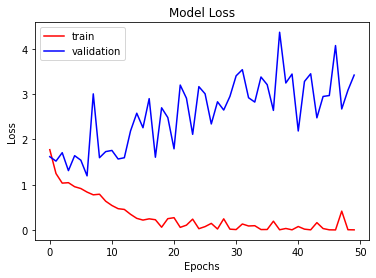

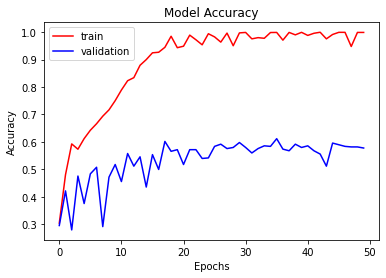

In [14]:
# Loss
plt.plot(History.history['loss'], "r")
plt.plot(History.history['val_loss'], "b")
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])
plt.show()

# Accuracy
plt.plot(History.history['accuracy'], "r")
plt.plot(History.history['val_accuracy'],"b")
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])
plt.show()

In [16]:
flower_url = "/content/sample_data/dendalian.jpg"

img = keras.preprocessing.image.load_img(
    flower_url, target_size=(150, 150)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {}"
    .format(flowers[np.argmax(score)])
)

1/1 [==============================] - 0s 15ms/step
This image most likely belongs to daisy
